revisar pq se ha cambiado la forma de cargar pesos e implementar la red

POR HACER
* cargar archivos txt, pickle o hd5py (unificar)
* refactorizar codigo
* implementar bucle o funcion para leer el conjunto test y obtener la matriz de confusion
* revisar codigo alternativa 1 y 2


HECHOS
* crear modelo cambiando la ultima capa y congelar capas a partir de la ultima convolucional
* cargar pesos
* compilar
* muestras train, val y test

Comentarios:

* parametros a tunear
    
    * input de 150x150 mejora mucho frente a 224x224 (aunque se use bicubic o lanzcos)
    * numero de capas y  cantidad 256 // 1024 // 2048 // 4096
    * loss functions https://keras.io/losses/
    * softmax (algunos autores incluso en multiclass usan sigmoid ¿?)
    * optimizer rmsprop (creo q es el apropiado) vs SGD con lr 0.01 y 0.001
    
mejores resultados con softmax (que creo que son los adecuados)

1.- 1 capa dense de 256 sgd con lr 0.01 --> 88.60% con loss 0.3513

2.- 1 capa dense de 256 rmsprop --> 89.1% con loss 0.8582

3.- 2 capa dense de 1024 rmsprop --> 87.80% con loss 1.1068

4.- 1 capa dense de 1024 rmsprop --> 89.70% con loss 1.0047

        

In [ ]:
# http://www.codesofinterest.com/2017/08/bottleneck-features-multi-class-classification-keras.html

In [1]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras import applications
from keras.optimizers import SGD
from keras.utils.np_utils import to_categorical
import matplotlib.pyplot as plt
import math
import os
# import cv2

Using TensorFlow backend.


In [2]:
# dimensions of our images.
img_width, img_height = 150, 150

top_model_weights_path = '../data/output_convnet/bottleneck_fc_model.h5'
train_data_dir = 'train'
validation_data_dir = 'validation'
test_data_dir = 'test'

# number of epochs to train top model
epochs = 50
# batch size used by flow_from_directory and predict_generator
batch_size = 16

In [3]:
def save_bottlebeck_features():
    # build the VGG16 network
    model = applications.VGG16(include_top=False, weights='imagenet')

    datagen = ImageDataGenerator(rescale=1. / 255)

    generator = datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)

    print(len(generator.filenames))
    print(generator.class_indices)
    print(len(generator.class_indices))

    nb_train_samples = len(generator.filenames)
    num_classes = len(generator.class_indices)

    predict_size_train = int(math.ceil(nb_train_samples / batch_size))

    bottleneck_features_train = model.predict_generator(
        generator, predict_size_train)

    np.save('../data/output_convnet/bottleneck_features_train.npy', bottleneck_features_train)

    generator = datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)

    nb_validation_samples = len(generator.filenames)

    predict_size_validation = int(
        math.ceil(nb_validation_samples / batch_size))

    bottleneck_features_validation = model.predict_generator(
        generator, predict_size_validation)

    np.save('../data/output_convnet/bottleneck_features_validation.npy',
            bottleneck_features_validation)

In [4]:
from time import time # execution time no the best accurate but the easiest sometimes does not work

ti_bn_features = time()

save_bottlebeck_features()

tf_bn_features = time()    

tt_bn_features = tf_bn_features - ti_bn_features

Found 3000 images belonging to 8 classes.
3000
{'01_TUMOR': 0, '02_STROMA': 1, '03_COMPLEX': 2, '04_LYMPHO': 3, '05_DEBRIS': 4, '06_MUCOSA': 5, '07_ADIPOSE': 6, '08_EMPTY': 7}
8
Found 1000 images belonging to 8 classes.


In [5]:
import time
print(time.strftime("%H:%M:%S", time.gmtime(tt_bn_features)))

00:00:32


In [33]:
def train_top_model():
    datagen_top = ImageDataGenerator(rescale=1. / 255)
    generator_top = datagen_top.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

    nb_train_samples = len(generator_top.filenames)
    num_classes = len(generator_top.class_indices)

    # save the class indices to use use later in predictions
    np.save('../data/output_convnet/class_indices.npy', generator_top.class_indices)

    # load the bottleneck features saved earlier
    train_data = np.load('../data/output_convnet/bottleneck_features_train.npy')

    # get the class lebels for the training data, in the original order
    train_labels = generator_top.classes

    # https://github.com/fchollet/keras/issues/3467
    # convert the training labels to categorical vectors
    train_labels = to_categorical(train_labels, num_classes=num_classes)

    generator_top = datagen_top.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)

    nb_validation_samples = len(generator_top.filenames)

    validation_data = np.load('../data/output_convnet/bottleneck_features_validation.npy')

    validation_labels = generator_top.classes
    validation_labels = to_categorical(
        validation_labels, num_classes=num_classes)
    
    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:]))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(8, activation='softmax'))

#     model = Sequential()
#     model.add(Flatten(input_shape=train_data.shape[1:]))
#     model.add(Dense(4096, activation='relu'))
#     model.add(Dropout(0.5))
# #     model.add(Dense(8, activation='sigmoid'))
#     model.add(Dense(8, activation='softmax'))

#     model = Sequential()
#     model.add(Flatten(input_shape=train_data.shape[1:]))
#     model.add(Dense(2048, activation='relu'))
#     model.add(Dropout(0.5))
#     model.add(Dense(2048, activation='relu'))
#     model.add(Dropout(0.5))
#     model.add(Dense(8, activation='softmax'))

    learning_rate = 0.01
    
    model.compile(optimizer=SGD(lr=learning_rate),
                  loss='categorical_crossentropy', metrics=['accuracy'])

#     model.compile(optimizer='rmsprop',
#                   loss='categorical_crossentropy', metrics=['accuracy'])

    
    history = model.fit(train_data, train_labels,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(validation_data, validation_labels))

    model.save_weights(top_model_weights_path)

    (eval_loss, eval_accuracy) = model.evaluate(
        validation_data, validation_labels, batch_size=batch_size, verbose=1)

    print("[INFO] accuracy: {:.2f}%".format(eval_accuracy * 100))
    print("[INFO] Loss: {}".format(eval_loss))

    plt.figure(1)

    # summarize history for accuracy

    plt.subplot(211)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')

    # summarize history for loss

    plt.subplot(212)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

Found 3000 images belonging to 8 classes.
Found 1000 images belonging to 8 classes.
Train on 3000 samples, validate on 1000 samples
Epoch 1/50
3000/3000 [==============================] - 2s 564us/step - loss: 1.4991 - acc: 0.4507 - val_loss: 1.1149 - val_acc: 0.5300
Epoch 2/50
3000/3000 [==============================] - 1s 365us/step - loss: 1.0084 - acc: 0.6403 - val_loss: 0.7962 - val_acc: 0.7360
Epoch 3/50
3000/3000 [==============================] - 1s 373us/step - loss: 0.8493 - acc: 0.6983 - val_loss: 0.8611 - val_acc: 0.6500
Epoch 4/50
3000/3000 [==============================] - 1s 382us/step - loss: 0.7556 - acc: 0.7373 - val_loss: 0.6925 - val_acc: 0.7490
Epoch 5/50
3000/3000 [==============================] - 1s 383us/step - loss: 0.7112 - acc: 0.7393 - val_loss: 0.5919 - val_acc: 0.7800
Epoch 6/50
3000/3000 [==============================] - 1s 349us/step - loss: 0.6431 - acc: 0.7773 - val_loss: 0.5656 - val_acc: 0.7800
Epoch 7/50
3000/3000 [==============================

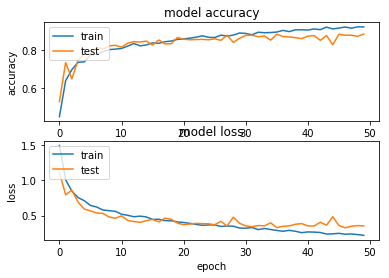

In [34]:
from time import time # execution time no the best accurate but the easiest sometimes does not work

ti_bn_train = time()

train_top_model()

tf_bn_train = time()    

tt_bn_train = tf_bn_train - ti_bn_train

In [35]:
import time
print(time.strftime("%H:%M:%S", time.gmtime(tt_bn_train)))

00:00:58


In [ ]:
def predict():
    # load the class_indices saved in the earlier step
    class_dictionary = np.load('class_indices.npy').item()

    num_classes = len(class_dictionary)

    # add the path to your test image below
    image_path = test_data_dir

    orig = cv2.imread(image_path)

    print("[INFO] loading and preprocessing image...")
    image = load_img(image_path, target_size=(224, 224))
    image = img_to_array(image)

################################################
#     #pre procesado de imagen
#     img = image.load_img(img_path, target_size=(224, 224), interpolation='lanczos')
#     x = image.img_to_array(img)
#     x = np.expand_dims(x, axis=0)
#     x = preprocess_input(x)
################################################

    # important! otherwise the predictions will be '0'
    image = image / 255

    image = np.expand_dims(image, axis=0)

    # build the VGG16 network
    model = applications.VGG16(include_top=False, weights='imagenet')

    # get the bottleneck prediction from the pre-trained VGG16 model
    bottleneck_prediction = model.predict(image)

    # build top model
    model = Sequential()
    model.add(Flatten(input_shape=bottleneck_prediction.shape[1:]))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(8, activation='sigmoid'))

    model.load_weights(top_model_weights_path)

    # use the bottleneck prediction on the top model to get the final
    # classification
    class_predicted = model.predict_classes(bottleneck_prediction)

    probabilities = model.predict_proba(bottleneck_prediction)

    inID = class_predicted[0]

    inv_map = {v: k for k, v in class_dictionary.items()}

    label = inv_map[inID]

    # get the prediction label
    print("Image ID: {}, Label: {}".format(inID, label))

    # display the predictions with the image
    cv2.putText(orig, "Predicted: {}".format(label), (10, 30),
                cv2.FONT_HERSHEY_PLAIN, 1.5, (43, 99, 255), 2)

    cv2.imshow("Classification", orig)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [ ]:
predict()

# alternativa 1 no funciona correctamente

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras import applications
from keras.optimizers import SGD
import numpy as np

In [ ]:
# dimensions of our images.
img_width, img_height = 150, 150 # con el resize a 224 no funciona

# top_model_weights_path = '../data/output_convnet/bottleneck_fc_model.h5'
# train_data_dir = '../data/samples/train'
# validation_data_dir = '../data/samples/validation'

top_model_weights_path = 'bottleneck_fc_model.h5'
train_data_dir = 'train'
validation_data_dir = 'validation'

nb_train_samples = 3000
nb_validation_samples = 1000
epochs = 50
batch_size = 10

In [ ]:
# esto es algo parecido a deepfeatures

def save_bottlebeck_features():
    datagen = ImageDataGenerator(rescale=1. / 255)

    # build the VGG16 network
    model = applications.VGG16(include_top=False, weights='imagenet')
    
    generator = datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)
    
    
    bottleneck_features_train = model.predict_generator(
        generator, nb_train_samples // batch_size)
    
    np.save(open('bottleneck_features_train.npy', 'wb'),
            bottleneck_features_train)

    print("se salva el archivo 1 y comienza el segundo generador")
    generator = datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)
    
    bottleneck_features_validation = model.predict_generator(
        generator, nb_validation_samples // batch_size)
    
    np.save(open('bottleneck_features_validation.npy', 'wb'),
            bottleneck_features_validation)

In [ ]:
from time import time # execution time no the best accurate but the easiest sometimes does not work

In [ ]:
ti_bn_features = time()

save_bottlebeck_features()

tf_bn_features = time()    

tt_bn_features = tf_bn_features - ti_bn_features

In [ ]:
import time
print(time.strftime("%H:%M:%S", time.gmtime(tt_bn_features)))

In [ ]:
# # para que este punto
# '''
# the generator will only yield batches of image data, which is useful
# to use model.predict_generator(),  model.evaluate_generator()
# '''
# train_labels = np.array(
#         [0] * (nb_train_samples // 2) + [1] * (nb_train_samples // 2))

# validation_labels = np.array(
#         [0] * (nb_validation_samples // 2) + [1] * (nb_validation_samples // 2))

In [ ]:
# print(train_labels)

In [ ]:
# print(validation_labels)

In [ ]:
def train_top_model():
    train_data = np.load(open('bottleneck_features_train.npy','rb'))
    train_labels = np.array(
        [0] * (nb_train_samples // 2) + [1] * (nb_train_samples // 2))

    
    validation_data = np.load(open('bottleneck_features_validation.npy','rb')) 
    validation_labels = np.array(
        [0] * (nb_validation_samples // 2) + [1] * (nb_validation_samples // 2))

    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:]))
    model.add(Dense(4096, activation='relu', name = "fc1"))
    model.add(Dropout(0.5))
    model.add(Dense(4096, activation='relu', name = "fc2"))
    model.add(Dropout(0.5))
    model.add(Dense(8, activation='softmax', name = "new_cats"))

#     model.compile(optimizer=SGD(), loss='categorical_crossentropy') # no arranca
#     model.compile(optimizer=SGD(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
#     model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    my_sgd = SGD(lr=0.001)
    model.compile(optimizer=my_sgd,
                  loss='categorical_crossentropy', metrics=['accuracy'])

    model.fit(train_data, train_labels,
              epochs=epochs,
              batch_size=batch_size,
              validation_data=(validation_data, validation_labels))
    model.save_weights(top_model_weights_path)

In [ ]:
from time import time

ti_bn_train = time()

train_top_model()

tf_bn_train = time()    

tt_bn_train = tf_bn_train - ti_bn_train

In [ ]:
'''
@srikar2097, I found the reason for that issue. 
flow_from_directory selects from one folder at a 
time and as there are more then 2000 images in the 
first folder (13k for me) it just takes images from one folder/class 
but still pretends like the val data is half from one class half from the other. See line 145.'''

In [ ]:
import time
print(time.strftime("%H:%M:%S", time.gmtime(tt_bn_train)))

In [ ]:
# https://stackoverflow.com/questions/39376169/keras-convolution2d-input-error-when-checking-model-input-expected-convolution
img = load_img('my_img.jpg',False, (img_width, img_height))
x = img_to_array(img)
prediction = model.predict(x.reshape((1,3,img_width, img_height)),batch_size=32, verbose=0)
print(prediction)

In [ ]:
'''
https://stackoverflow.com/questions/36927025/how-to-use-keras-multi-layer-perceptron-for-multi-class-classification
For multiclass prediction you need to convert your labels via to_categorical. 
https://github.com/keras-team/keras/blob/master/keras/utils/np_utils.py#L9


For more info see this:

http://stackoverflow.com/questions/36927025/how-to-use-keras-multi-layer-perceptron-for-multi-class-classification
'''

# alternativa 2 no funciona correctamente

In [ ]:
from time import time # execution time no the best accurate but the easiest sometimes does not work

In [ ]:
n_categories = 8 # numero de categorias en las que clasificar las imagenes

In [ ]:
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import numpy as np

In [ ]:
# comprobar si el modelo es vgg16 como el implementado en keras
# https://github.com/keras-team/keras/blob/master/keras/applications/vgg16.py # estructura implementada en keras
model = Sequential()
model.add(ZeroPadding2D((1,1),input_shape=(224,224,3)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(Flatten())

#top layer of the VGG net
model.add(Dense(4096, activation='relu',name="fc1"))
model.add(Dropout(0.5))
model.add(Dense(4096, activation='relu',name="fc2"))
model.add(Dropout(0.5))
model.add(Dense(1000, activation='softmax',name="last_layer"))

# model.summary() # lo oculto por ahora

In [ ]:
model.load_weights("keras_weights/vgg16_weights_tf_dim_ordering_tf_kernels.h5")

In [ ]:
model.layers.pop()
model.outputs = [model.layers[-1].output]
model.layers[-1].outbound_nodes = []

# activacion softmax para calcular multiclasificacion
model.add(Dense(n_categories, activation='softmax',name="new_cats"))

In [ ]:
model.summary()

In [ ]:
# for i, layer in enumerate(model.layers):
#     print (i, layer.name, layer.output_shape)

In [ ]:
# congelamos todas salvo las fc1 fc2 y new_cats, en estas los pesos se actualizaran (entrenaran)
for layer in model.layers[:31]:
    layer.trainable = False

In [ ]:
for i, layer in enumerate(model.layers):
    if layer.trainable:
        print("layer {0:s} is trainable".format(layer.name))
    else:
        print("layer {0:s} is freezed".format(layer.name))

In [ ]:
# revisar estos hiperparametros --> leer sobre ellos y tomar decisiones
# sgd = SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)
# model.compile(optimizer=SGD(), loss='categorical_crossentropy', metrics=['accuracy'])

# compilamos este como el caso anterior para poder compararlos
model.compile(optimizer=SGD(), loss='categorical_crossentropy')

In [ ]:
# ahora ya hay que pasarle lista de fotografias a entrenar

In [ ]:
# https://keras.io/models/sequential/

scores = []

ti_bn_fit = time()

for i, index_path in enumerate(img_list_train):
    
    # img preparation
    img = image.load_img(index_path, target_size=(224, 224), interpolation='lanczos')
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    
    # model init
#     model.fit(x, labels_train[i], verbose=1, validation_split=0.2)
    model.fit(x, labels_train[i], verbose=1)

    # model eval
#     score = model.evaluate(x, labels_train[i], verbose=1)
    
#     scores.append(score[1] * 100)

tf_bn_fit = time()    

tt_bn_fit = tf_bn_fit - ti_bn_fit

In [ ]:
import time
print(time.strftime("%H:%M:%S", time.gmtime(tt_bn_fit)))

In [ ]:
#resultados

In [ ]:
# https://keras.io/models/sequential/
ti_bn_evaluate = time()

model.evaluate(img_list_test, labels_test,verbose=1)

tf_bn_evaluate = time()    

tt_bn_evaluate = tf_bn_evaluate - ti_bn_evaluate

In [ ]:
import time
print(time.strftime("%H:%M:%S", time.gmtime(tt_bn_evaluate)))

In [ ]:
#resultados

In [ ]:
# https://keras.io/models/sequential/
ti_bn_predict = time()

model.predict_classes(img_list_test,verbose=1)

tf_bn_predict = time()    

tt_bn_predict = tf_bn_predict - ti_bn_predictt

In [ ]:
import time
print(time.strftime("%H:%M:%S", time.gmtime(tt_bn_predict)))

In [ ]:
#resultados